In [ ]:
pip install xgboost


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# --- 1. Cargar y unir archivos ---
behavior = pd.read_csv("behavior_summary100N.csv")
behavior['cow_id'] = behavior['cow_id'] + 1
milk = pd.read_csv("milk_summary.csv")
weather = pd.read_csv("weather_summary.csv")

for df in [behavior, milk, weather]:
    df['date'] = df['date'].astype(str)

df = pd.merge(behavior, milk, on=['cow_id', 'date'])
df = pd.merge(df, weather, on='date')
df = df.sort_values(by=['cow_id', 'date'])

# --- 2. Crear milk_yesterday ---
df['milk_yesterday'] = df.groupby('cow_id')['milk_weight'].shift(1)
df = df.dropna()

# --- 3. Seleccionar features y target ---
feature_cols = [col for col in df.columns if col not in ['cow_id', 'date', 'milk_weight']]
target_col = 'milk_weight'

# Escalar (opcional, XGBoost no lo necesita pero puede ayudar con outliers)
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# --- 4. Dividir globalmente (80% train, 20% test sin mezcla por vaca) ---
from sklearn.model_selection import train_test_split

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# --- 5. Entrenar modelo XGBoost ---
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# --- 6. Evaluar ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nXGBoost Results:")
print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.2f}")



XGBoost Results:
Test MSE: 8.93
Test R²: 0.72


/tmp/ipykernel_1898977/1033300404.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


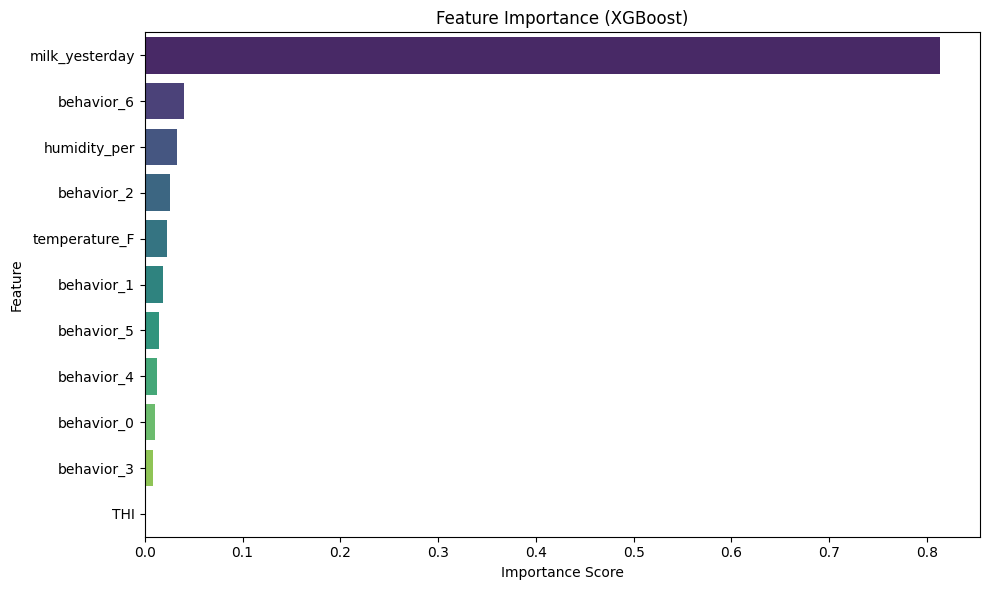

In [3]:
#----------1. Feature importance---------------
# Create a DataFrame for importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


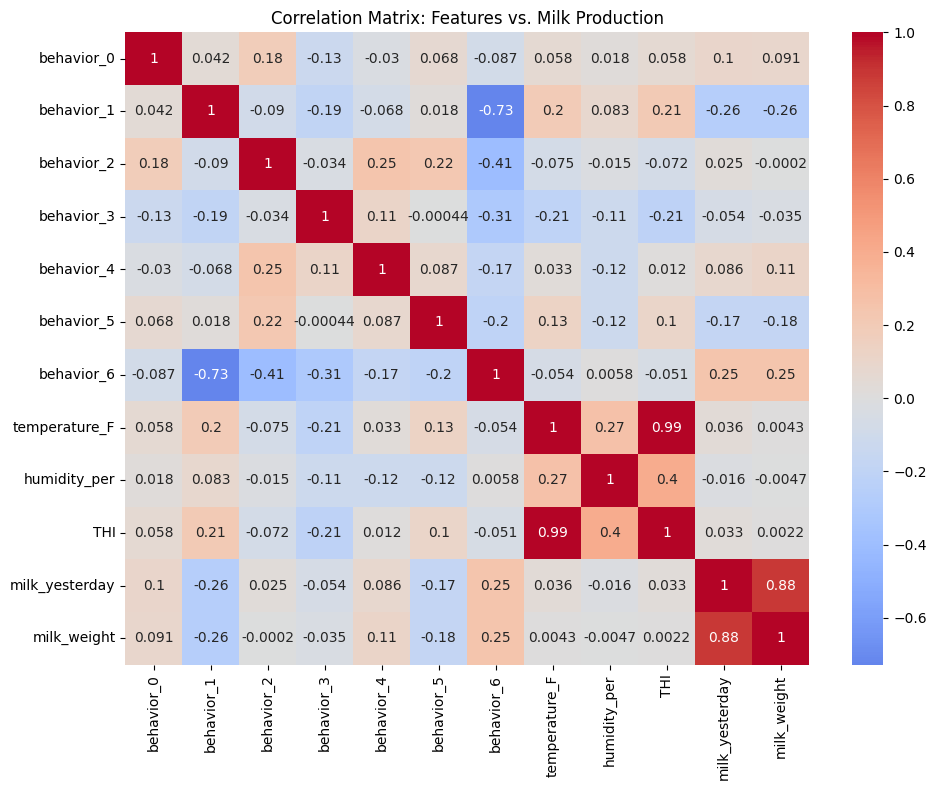

In [4]:
# Correlation matrix using the full dataset (scaled features + target)
df_corr = df[feature_cols + ['milk_weight']]
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Features vs. Milk Production")
plt.tight_layout()
plt.show()


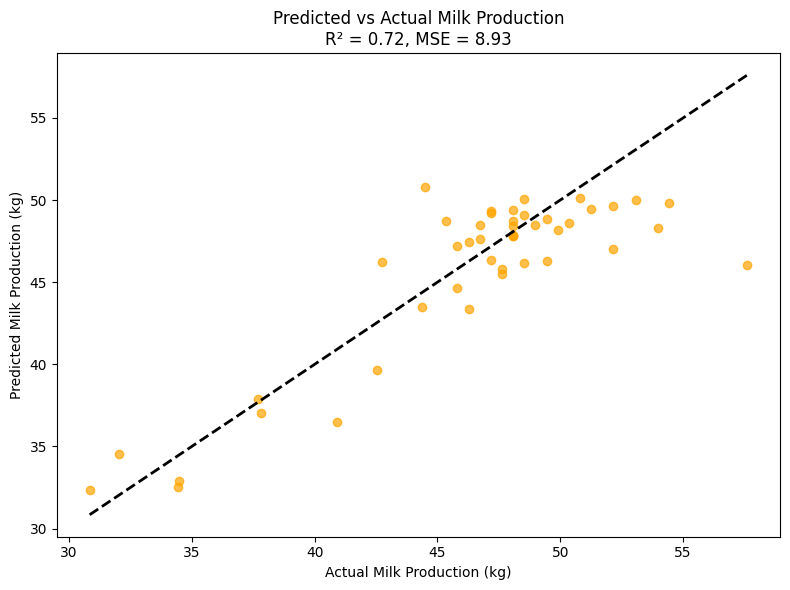

In [5]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Milk Production (kg)")
plt.ylabel("Predicted Milk Production (kg)")
plt.title(f"Predicted vs Actual Milk Production\nR² = {r2:.2f}, MSE = {mse:.2f}")
plt.tight_layout()
plt.show()


# Just Behavior

In [6]:
# --- Load and merge data ---
behavior = pd.read_csv("behavior_summary100N.csv")
behavior['cow_id'] = behavior['cow_id'] + 1
milk = pd.read_csv("milk_summary.csv")

for df in [behavior, milk]:
    df['date'] = df['date'].astype(str)

df = pd.merge(behavior, milk, on=['cow_id', 'date'])

# --- Define features and target ---
behavior_cols = [col for col in df.columns if col.startswith('behavior_')]
X = df[behavior_cols]
y = df['milk_weight']

# --- Optional: scale behaviors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=behavior_cols)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Train XGBoost model ---
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# --- Evaluate ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n[XGBoost with behavior only]")
print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.2f}")



[XGBoost with behavior only]
Test MSE: 34.74
Test R²: 0.13


/tmp/ipykernel_1898977/1033300404.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


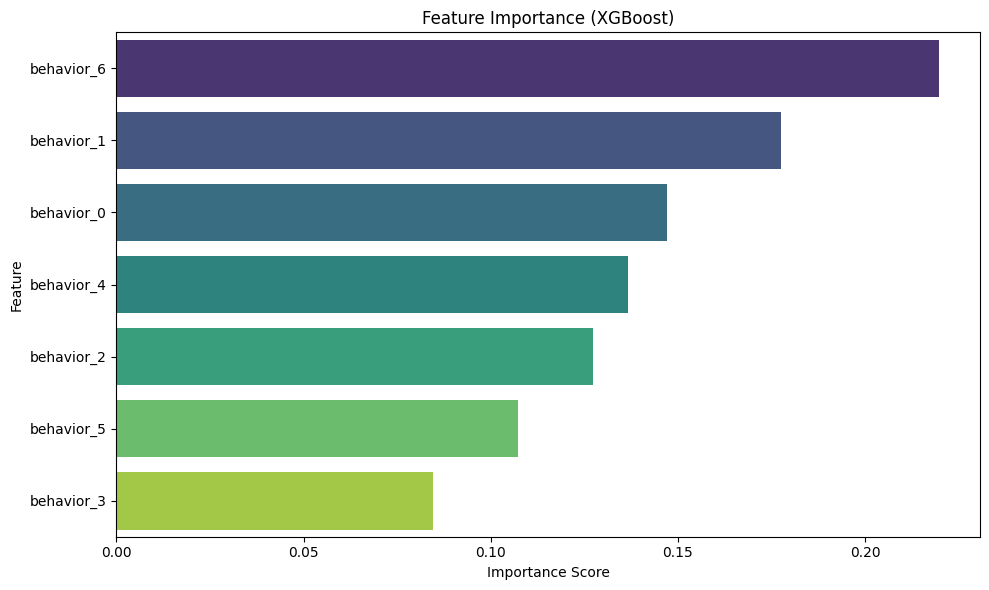

In [7]:
#----------1. Feature importance---------------
# Create a DataFrame for importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


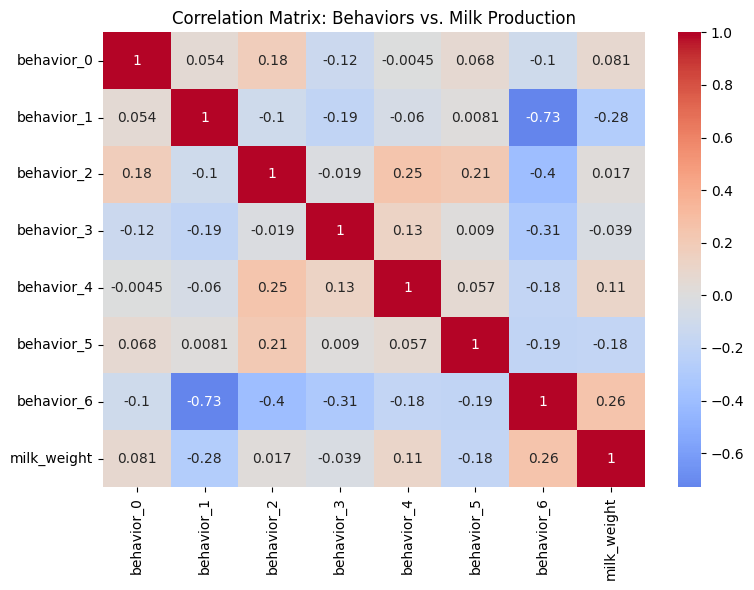

In [8]:

# Create correlation matrix with behavior features and milk_weight
df_corr = df[behavior_cols + ['milk_weight']].copy()
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Behaviors vs. Milk Production")
plt.tight_layout()
plt.show()


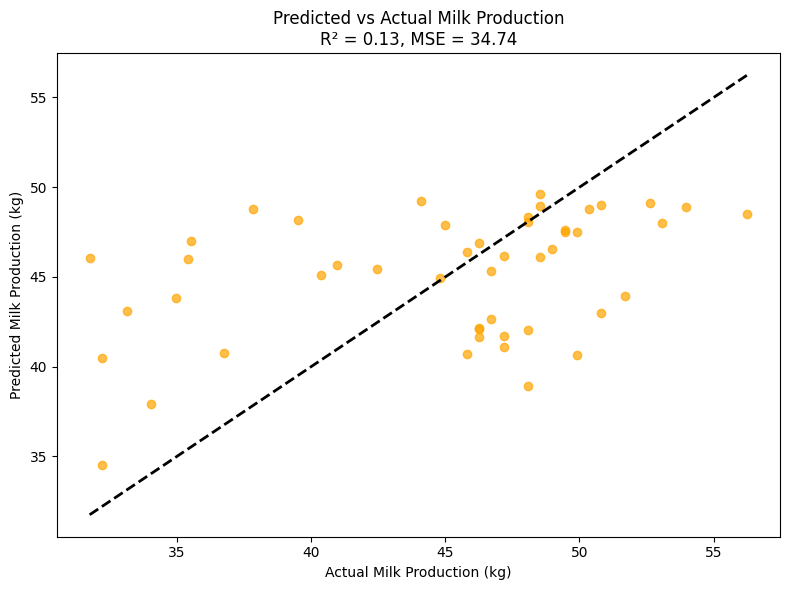

In [9]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Milk Production (kg)")
plt.ylabel("Predicted Milk Production (kg)")
plt.title(f"Predicted vs Actual Milk Production\nR² = {r2:.2f}, MSE = {mse:.2f}")
plt.tight_layout()
plt.show()

In [ ]:
# Behavior & Milk yesteday

In [10]:
# --- Load data ---
behavior = pd.read_csv("behavior_summary100N.csv")
behavior['cow_id'] = behavior['cow_id'] + 1
milk = pd.read_csv("milk_summary.csv")

# Convert date to string
for df in [behavior, milk]:
    df['date'] = df['date'].astype(str)

# Merge behavior and milk data
df = pd.merge(behavior, milk, on=['cow_id', 'date'])
df = df.sort_values(by=['cow_id', 'date'])

# Create milk_yesterday feature
df['milk_yesterday'] = df.groupby('cow_id')['milk_weight'].shift(1)

# Drop rows with missing milk_yesterday
df = df.dropna()

# --- Select features ---
behavior_cols = [col for col in df.columns if col.startswith('behavior_')]
feature_cols = behavior_cols + ['milk_yesterday']
X = df[feature_cols]
y = df['milk_weight']

# --- Scale features (optional) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

# --- Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Train XGBoost model ---
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# --- Evaluate ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n[XGBoost - Behaviors + Milk Yesterday]")
print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.2f}")



[XGBoost - Behaviors + Milk Yesterday]
Test MSE: 8.53
Test R²: 0.73


/tmp/ipykernel_1898977/1033300404.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


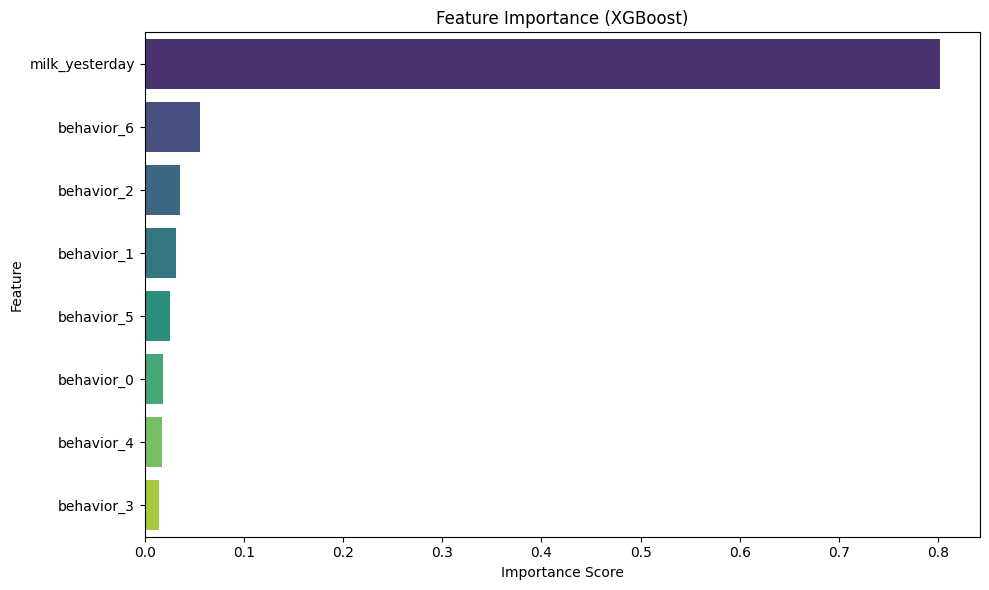

In [11]:
#----------1. Feature importance---------------
# Create a DataFrame for importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


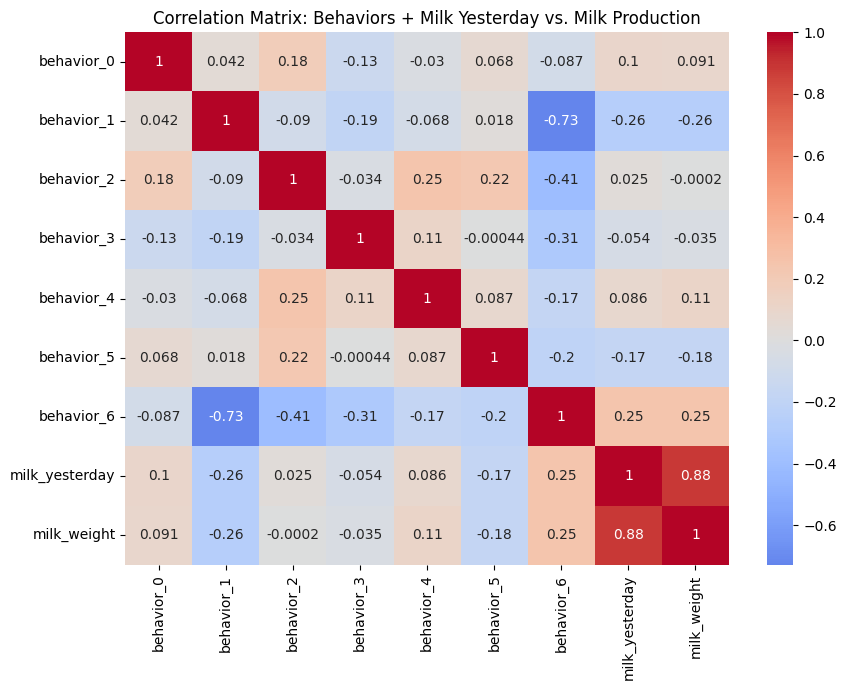

In [12]:

# Define selected features for correlation
correlation_features = behavior_cols + ['milk_yesterday', 'milk_weight']

# Create correlation matrix
df_corr = df[correlation_features].copy()
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Behaviors + Milk Yesterday vs. Milk Production")
plt.tight_layout()
plt.show()

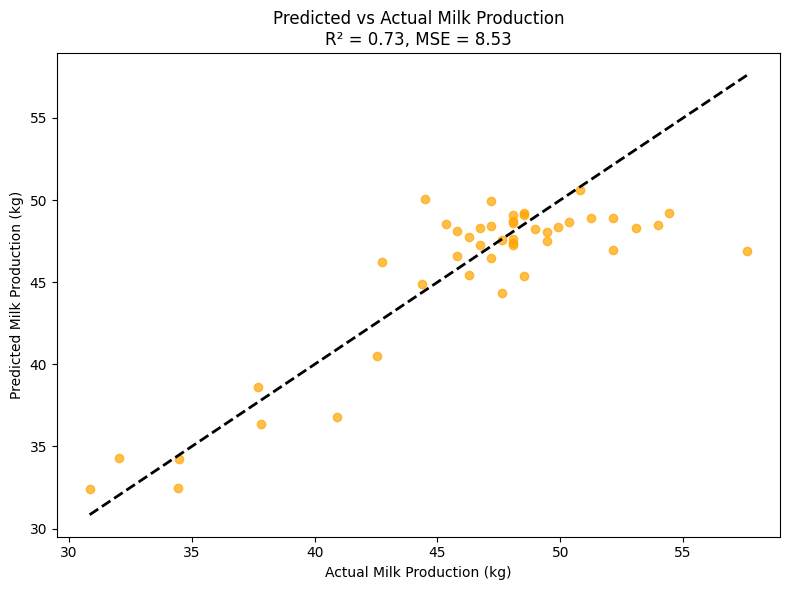

In [13]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Milk Production (kg)")
plt.ylabel("Predicted Milk Production (kg)")
plt.title(f"Predicted vs Actual Milk Production\nR² = {r2:.2f}, MSE = {mse:.2f}")
plt.tight_layout()
plt.show()